In [1]:
import pandas as pd
import os
import numpy as np
import random
import json
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from utils import loadWord2Vec, clean_str
from math import log
from sklearn import svm
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from collections import defaultdict

In [2]:
#Location of each resource type
#['category'][0]['coding'][0]['display'], Careplan

#['type'][0]['text'], encounter
#['vaccineCode']['coding'][0]['display'], immunization
#['medicationCodeableConcept']['coding'][0]['display'], medication
#['type']['coding'][0]['display']
#['id'], patient
#['code']['coding'][0]['display'], Procedure
#['code']['coding'][0]['display'], condition
#['code']['coding'][0]['display'], observation
#['code']['coding'][0]['display'], diagonstic report

#['vaccineCode']['coding'][0]['display'], immunization
#['medicationCodeableConcept']['coding'][0]['display'], medication


### Change the SYNTHEA STU-3 FHIR data to pandas dataframe 

In [5]:
directory = os.fsencode('../SYNTHEA/')
encounters,conditions,patient_ids,procedures, observations, dignotstics_reports, immunizations, medication_orders, careplans = ([] for _ in range(9))

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    with open('../SYNTHEA/'+filename, "r") as read_file:
        data = json.load(read_file)
        resources = data['entry']
        patient_id = resources[0]['resource']['id']
        patient_ids.append(patient_id)
        patient_encounters,patient_conditions, patient_procedures,patient_observations, patient_diagnostics_reports, patient_immunizations, patient_medication_orders, patient_careplans = (set() for _ in range(8))
   
        for resource in resources:
            resource_type = resource['resource']['resourceType']
            if resource_type =='Encounter':
                patient_encounters.add(resource['resource']['type'][0]['coding'][0]['code'])
            elif resource_type =='Condition':
                patient_conditions.add(resource['resource']['code']['coding'][0]['code'])
            elif resource_type =='Procedure':
                code = resource['resource']['code']['coding'][0]['code']
                #ignore documentation of current medications
                if code!='428191000124101':
                    patient_procedures.add(code)  
            elif resource_type =='Observation':
                patient_observations.add(resource['resource']['code']['coding'][0]['code'])
            elif resource_type =='DiagnosticReport':
                patient_diagnostics_reports.add(resource['resource']['code']['coding'][0]['code'])
            elif resource_type == 'Immunization':
                patient_immunizations.add(resource['resource']['vaccineCode']['coding'][0]['code'])
            elif resource_type == 'MedicationOrder':
                patient_medication_orders.add(resource['resource']['medicationCodeableConcept']['coding'][0]['code'])
            elif resource_type == 'CarePlan':
                patient_careplans.add(resource['resource']['category'][0]['coding'][0]['code'])
        encounters.append(','.join(patient_encounters))
        conditions.append(','.join(patient_conditions))
        procedures.append(','.join(patient_procedures))
        observations.append(','.join(patient_observations))
        dignotstics_reports.append(','.join(patient_diagnostics_reports))
        immunizations.append(','.join(patient_immunizations))
        medication_orders.append(','.join(patient_medication_orders))
        careplans.append(','.join(patient_careplans))
        
        
data = {'patient': patient_ids,'Encounter': encounters, 'Condition': conditions, 'Procedure':procedures, 'Observation':observations, 
        'Diagnostics Report':dignotstics_reports, 'Immunization':immunizations, 'Medication Orders':medication_orders, 'Careplan': careplans}
resource_df = pd.DataFrame(data)

In [6]:
resource_df.head()

,patient,Encounter,Condition,Procedure,Observation,Diagnostics Report,Immunization,Medication Orders,Careplan
0,9f59ec59-5116-401b-bcbb-f019a6ca7a4f,"183495009,50849002,185349003,170258001,185345009","444814009,359817006,444470001,195662009,444650...","305428000,699253003,269911007","8302-2,29463-7,39156-5,8331-1,55284-4",,"115,114,62,140","857005,198405,310965,608680","385691007,53950000,91251008"
1,765382db-8551-4733-8658-d9fc7b0f7ee8,"185349003,185345009","444814009,368581000119106,195662009,15777000,3...",23426006,"2069-3,4548-4,8331-1,2947-0,18262-6,2339-0,294...","57698-3,51990-0","113,140","860975,608680","53950000,698360004"
2,63927398-3432-4526-9960-0da4359e3be2,"185349003,170258001,185345009","444814009,43878008,275272006",117015009,"8302-2,29463-7,39156-5,8331-1,55284-4",,"113,114,62,140","834101,824184",
3,7af203fe-86af-42a9-b6ee-f2c2828ead13,"185349003,185345009","444814009,38341003,40055000",,"8302-2,29463-7,2571-8,2093-3,39156-5,33914-3,1...",57698-3,"113,140",824184,
4,9a0ea485-3bba-457f-bcaa-8cbb8fba34ef,"185349003,183452005,50849002,185345009","74400008,444814009,428251008,195662009,6210600...",80146002,"2069-3,4548-4,8331-1,2947-0,18262-6,2339-0,294...","57698-3,51990-0","121,113,140",860975,"47387005,698360004"


In [7]:
resource_df.columns

Index(['patient', 'Encounter', 'Condition', 'Procedure', 'Observation',
       'Diagnostics Report', 'Immunization', 'Medication Orders', 'Careplan'],
      dtype='object')

In [8]:
res = resource_df.replace('', np.nan)

In [9]:
res.isnull().sum()

patient                 0
Encounter               1
Condition              47
Procedure             393
Observation             3
Diagnostics Report    312
Immunization          209
Medication Orders      91
Careplan              156
dtype: int64

In [10]:
#drop patients with null values for datasets understudy
res_condition = res.dropna(axis=0, how='any', subset=['Condition','Procedure', 'Medication Orders', 'Observation'])

In [11]:
res_condition.shape

(593, 9)

In [12]:
res_condition.isnull().sum()

patient                 0
Encounter               0
Condition               0
Procedure               0
Observation             0
Diagnostics Report    211
Immunization            2
Medication Orders       0
Careplan               24
dtype: int64

In [13]:
diseases = []
disease_bundled = []
for condition in res_condition['Condition'].values:
    diseases.extend(condition.split(','))
    disease_bundled.append(condition.split(','))

In [14]:
len(diseases)

2904

In [15]:
from collections import Counter

disease_count = Counter(diseases)

In [16]:
disease_count

Counter({'444814009': 364,
         '359817006': 7,
         '444470001': 5,
         '195662009': 250,
         '44465007': 54,
         '10509002': 263,
         '368581000119106': 11,
         '15777000': 176,
         '38341003': 164,
         '44054006': 24,
         '43878008': 106,
         '275272006': 3,
         '74400008': 31,
         '428251008': 31,
         '62106007': 34,
         '422034002': 6,
         '410429000': 18,
         '72892002': 88,
         '398254007': 9,
         '33737001': 12,
         '39848009': 34,
         '429007001': 18,
         '239873007': 29,
         '230690007': 28,
         '195967001': 18,
         '367498001': 10,
         '65363002': 72,
         '233678006': 21,
         '26929004': 13,
         '233604007': 3,
         '162573006': 11,
         '423121009': 7,
         '254637007': 10,
         '82423001': 4,
         '15724005': 1,
         '40055000': 104,
         '284549007': 18,
         '403190006': 18,
         '19169002': 16,

<BarContainer object of 109 artists>

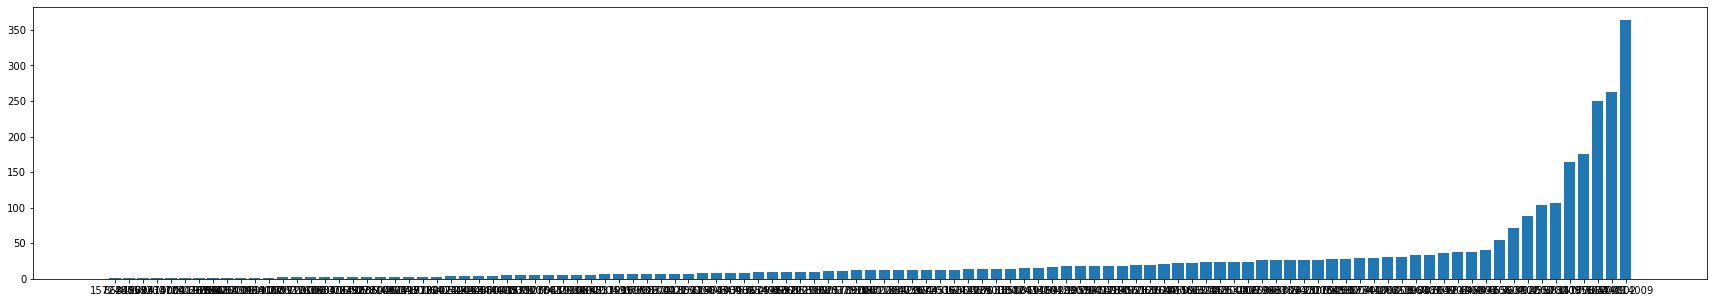

In [17]:
import matplotlib.pyplot as plt
disease_count_sorted = dict(sorted(disease_count.items(), key= lambda item: item[1]))
cases = list(disease_count_sorted.keys())
count = list(disease_count_sorted.values())
fig = plt.figure(figsize=(30,5))
plt.bar(cases, count)

In [18]:
disease_count_sorted

{'15724005': 1,
 '86849004': 1,
 '287182007': 1,
 '262574004': 1,
 '157141000119108': 1,
 '97331000119101': 1,
 '230265002': 1,
 '69896004': 1,
 '254632001': 1,
 '67841000119103': 1,
 '609496007': 1,
 '196416002': 1,
 '1501000119109': 2,
 '239720000': 2,
 '93761005': 2,
 '110030002': 2,
 '363406005': 2,
 '37849005': 2,
 '275272006': 3,
 '233604007': 3,
 '90781000119102': 3,
 '425048006': 3,
 '239872002': 3,
 '124171000119105': 3,
 '82423001': 4,
 '403192003': 4,
 '444448004': 4,
 '90560007': 4,
 '444470001': 5,
 '109838007': 5,
 '197927001': 5,
 '1551000119108': 5,
 '55680006': 5,
 '422034002': 6,
 '198992004': 6,
 '359817006': 7,
 '423121009': 7,
 '35999006': 7,
 '307731004': 7,
 '30832001': 7,
 '127013003': 7,
 '40275004': 7,
 '85116003': 8,
 '62564004': 8,
 '47693006': 8,
 '84757009': 8,
 '398254007': 9,
 '367498001': 10,
 '254637007': 10,
 '399211009': 10,
 '22298006': 10,
 '368581000119106': 11,
 '162573006': 11,
 '33737001': 12,
 '713197008': 12,
 '38822007': 12,
 '201834006': 12

###  Choose conditions for study

In [19]:
candidates = list(disease_count_sorted.keys())[-5:]
print(candidates)

['38341003', '15777000', '195662009', '10509002', '444814009']


In [20]:
from collections import defaultdict
case_intersection = defaultdict(lambda: [])
for case1 in candidates:
    for case2 in candidates:
        count = 0
        for case in disease_bundled:
            if case1 in case and case2 in case:
                count+=1
        case_intersection[case1].append(count)
                
                
    

In [21]:
#Check comorbidity between candidates for study
case_intersection_df = pd.DataFrame(case_intersection, index = list(case_intersection.keys()))

In [22]:
case_intersection_df

,38341003,15777000,195662009,10509002,444814009
38341003,164,55,69,68,108
15777000,55,176,72,77,106
195662009,69,72,250,119,158
10509002,68,77,119,263,166
444814009,108,106,158,166,364


In [23]:
case_intersection_df.values[[np.arange(case_intersection_df.shape[0])]*2] = 0

/var/folders/9n/gzwg3s7j7pn060z120b3pb_h0000gn/T/ipykernel_1076/2729502969.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  case_intersection_df.values[[np.arange(case_intersection_df.shape[0])]*2] = 0


In [24]:
case_intersection_df

,38341003,15777000,195662009,10509002,444814009
38341003,0,55,69,68,108
15777000,55,0,72,77,106
195662009,69,72,0,119,158
10509002,68,77,119,0,166
444814009,108,106,158,166,0


In [25]:
case_intersection_df.sum(axis=1)

38341003     300
15777000     310
195662009    418
10509002     430
444814009    538
dtype: int64

In [26]:
candidates

['38341003', '15777000', '195662009', '10509002', '444814009']

In [27]:
common = []
for case in disease_bundled:
    common.append(np.in1d(np.array(candidates), np.array(case)).sum())

In [28]:
unique_indicies = []
for i in range(len(common)):
    if common[i]==1:
        unique_indicies.append(i)
        

In [29]:
len(unique_indicies)

143

In [30]:
selected_df = res_condition.iloc[unique_indicies]

In [31]:
selected_df.shape

(143, 9)

In [32]:
selected_df.head()

,patient,Encounter,Condition,Procedure,Observation,Diagnostics Report,Immunization,Medication Orders,Careplan
2,63927398-3432-4526-9960-0da4359e3be2,"185349003,170258001,185345009","444814009,43878008,275272006",117015009,"8302-2,29463-7,39156-5,8331-1,55284-4",NaN,"113,114,62,140","834101,824184",NaN
5,77e05358-bfd9-4399-a474-1fab36f31975,"424441002,698314001,50849002,185349003,1834600...","410429000,72892002,44465007,398254007,33737001...","66348005,31208007,274474001,252160004","8302-2,29463-7,39156-5,33914-3,55284-4",NaN,"115,114,62,140","757594,198405,310965,313782","385691007,698358001,91251008,134435003,8727810..."
9,fe1bba02-f021-4e12-81da-2b8f42988574,"183495009,50849002,185349003,698314001,185345009","10509002,444470001","699253003,269911007","8302-2,29463-7,2571-8,2093-3,39156-5,18262-6,5...",57698-3,"113,140","861467,831533,749762,834060,1020137,849574","53950000,91251008"
21,e223f58a-7029-4287-8e91-83b67336c3da,"185347001,170258001,185345009","444814009,233678006","171231001,395142003","6082-2,6276-0,6273-7,6075-6,6206-7,29463-7,609...",NaN,"140,119,133,83,20,08,49,10,21,03","727316,745679,895994,665078","326051000000105,699728000"
24,6979463f-b1ab-48c7-b560-b0b1782aa82e,"308646001,185349003,50849002,185347001","162573006,423121009,15777000,254637007","698354004,418891003,173160006,399208008,737610...","2339-0,38483-4,49765-1,8302-2,29463-7,2571-8,6...","69409-1,57698-3,51990-0","113,140","583214,1736854","182964004,698360004"


In [33]:
selected_df.isnull().sum()

patient                0
Encounter              0
Condition              0
Procedure              0
Observation            0
Diagnostics Report    72
Immunization           1
Medication Orders      0
Careplan              11
dtype: int64

### Prepare corpus

In [34]:
condition_df = selected_df[['patient','Procedure', 'Medication Orders', 'Condition']]

In [35]:
condition_df.isnull().sum()

patient              0
Procedure            0
Medication Orders    0
Condition            0
dtype: int64

In [36]:
condition_df.head()

,patient,Procedure,Medication Orders,Condition
2,63927398-3432-4526-9960-0da4359e3be2,117015009,"834101,824184","444814009,43878008,275272006"
5,77e05358-bfd9-4399-a474-1fab36f31975,"66348005,31208007,274474001,252160004","757594,198405,310965,313782","410429000,72892002,44465007,398254007,33737001..."
9,fe1bba02-f021-4e12-81da-2b8f42988574,"699253003,269911007","861467,831533,749762,834060,1020137,849574","10509002,444470001"
21,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003","727316,745679,895994,665078","444814009,233678006"
24,6979463f-b1ab-48c7-b560-b0b1782aa82e,"698354004,418891003,173160006,399208008,737610...","583214,1736854","162573006,423121009,15777000,254637007"


In [37]:
condition_df.shape

(143, 4)

In [38]:
len(condition_df['patient'].unique())

143

In [39]:
condition_df['Condition']=condition_df['Condition'].map(lambda x: list(set(x.split(',')) & set(candidates))[0])

/var/folders/9n/gzwg3s7j7pn060z120b3pb_h0000gn/T/ipykernel_1076/868148765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_df['Condition']=condition_df['Condition'].map(lambda x: list(set(x.split(',')) & set(candidates))[0])


In [40]:
condition_df.head()

,patient,Procedure,Medication Orders,Condition
2,63927398-3432-4526-9960-0da4359e3be2,117015009,"834101,824184",444814009
5,77e05358-bfd9-4399-a474-1fab36f31975,"66348005,31208007,274474001,252160004","757594,198405,310965,313782",38341003
9,fe1bba02-f021-4e12-81da-2b8f42988574,"699253003,269911007","861467,831533,749762,834060,1020137,849574",10509002
21,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003","727316,745679,895994,665078",444814009
24,6979463f-b1ab-48c7-b560-b0b1782aa82e,"698354004,418891003,173160006,399208008,737610...","583214,1736854",15777000


In [41]:
condition_df[condition_df['Condition']=='444814009']

,patient,Procedure,Medication Orders,Condition
2,63927398-3432-4526-9960-0da4359e3be2,117015009,"834101,824184",444814009
21,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003","727316,745679,895994,665078",444814009
44,df8f4853-e339-4af0-b423-26b7272bb48d,"288086009,22523008","313782,834060",444814009
56,6a511630-d43a-4380-9e60-b928f6287d5d,"274474001,117015009","834101,1367439,310965,834060",444814009
74,5238d34c-0005-4e3a-ae3b-12d260068af0,"46706006,117015009","834101,1373463,860975,897122",444814009
...,...,...,...,...
915,2ee68828-5d6c-4941-bee9-51cc4fb6a1bc,252160004,"757594,849574",444814009
917,471c24d2-f53b-4b45-a387-f51a44a542f8,"288086009,274474001","313782,751905",444814009
933,2f21c601-71f6-4ab9-ab66-1e227dc0db5e,228557008,"834060,849574",444814009
936,f150af1f-f166-4917-9678-685d6327efed,"305428000,312681000","861467,310965,1049221,834060,849574",444814009


In [42]:
condition_df['Document'] = condition_df['Procedure'].apply(lambda x : ' '.join(x.split(',')))+ ' ' + condition_df['Medication Orders'].apply(lambda x : ' '.join(x.split(',')))   

/var/folders/9n/gzwg3s7j7pn060z120b3pb_h0000gn/T/ipykernel_1076/663233480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_df['Document'] = condition_df['Procedure'].apply(lambda x : ' '.join(x.split(',')))+ ' ' + condition_df['Medication Orders'].apply(lambda x : ' '.join(x.split(',')))


In [43]:
condition_df.head()

,patient,Procedure,Medication Orders,Condition,Document
2,63927398-3432-4526-9960-0da4359e3be2,117015009,"834101,824184",444814009,117015009 834101 824184
5,77e05358-bfd9-4399-a474-1fab36f31975,"66348005,31208007,274474001,252160004","757594,198405,310965,313782",38341003,66348005 31208007 274474001 252160004 757594 1...
9,fe1bba02-f021-4e12-81da-2b8f42988574,"699253003,269911007","861467,831533,749762,834060,1020137,849574",10509002,699253003 269911007 861467 831533 749762 83406...
21,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003","727316,745679,895994,665078",444814009,171231001 395142003 727316 745679 895994 665078
24,6979463f-b1ab-48c7-b560-b0b1782aa82e,"698354004,418891003,173160006,399208008,737610...","583214,1736854",15777000,698354004 418891003 173160006 399208008 737610...


In [44]:
with open('data/corpus/disease.clean.txt', 'w') as f:
    for doc in condition_df['Document']:
        f.write(doc+'\n')
    

In [45]:
size = len(condition_df)
train_size = int(0.9*size)
test_size = size - train_size
print(size, train_size, test_size)

143 128 15


In [46]:
condition_df['Condition'].unique() 

array(['444814009', '38341003', '10509002', '15777000', '195662009'],
      dtype=object)

In [47]:
resource_df = condition_df.reset_index(drop=True)

In [48]:
resource_df.head()

,patient,Procedure,Medication Orders,Condition,Document
0,63927398-3432-4526-9960-0da4359e3be2,117015009,"834101,824184",444814009,117015009 834101 824184
1,77e05358-bfd9-4399-a474-1fab36f31975,"66348005,31208007,274474001,252160004","757594,198405,310965,313782",38341003,66348005 31208007 274474001 252160004 757594 1...
2,fe1bba02-f021-4e12-81da-2b8f42988574,"699253003,269911007","861467,831533,749762,834060,1020137,849574",10509002,699253003 269911007 861467 831533 749762 83406...
3,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003","727316,745679,895994,665078",444814009,171231001 395142003 727316 745679 895994 665078
4,6979463f-b1ab-48c7-b560-b0b1782aa82e,"698354004,418891003,173160006,399208008,737610...","583214,1736854",15777000,698354004 418891003 173160006 399208008 737610...


In [49]:
f2 = open("data/disease.txt", 'w')
for _,doc in condition_df[:train_size].iterrows():
    f2.write('data/disease/disease-train/'+doc['Condition']+'/'+doc['patient']+'\tdisease-train'+'\t'+doc['Condition']+'\n')
    with open('data/corpus/disease/disease-train/'+doc['Condition']+'/'+doc['patient'], 'w') as f:
        f.write(doc['Document'])
f2.close()

In [50]:
f2 = open("data/disease.txt", 'a')
for _,doc in condition_df[-test_size:].iterrows():
    f2.write('data/disease/disease-test/'+doc['Condition']+'/'+doc['patient']+'\tdisease-test'+'\t'+doc['Condition']+'\n')
    with open('data/corpus/disease/disease-test/'+doc['Condition']+'/'+doc['patient'], 'w') as f:
        f.write(doc['Document'])
f2.close()

### Build graph

In [133]:
dataset = 'disease'
word_embeddings_dim = 130

In [134]:
#train_test_split
size = len(resource_df)
train_size = int(0.9*size)
test_size = size - train_size
print(size, train_size, test_size)

143 128 15


In [135]:
#shuffling
train_ids = np.arange(train_size)
test_ids = np.arange(train_size, size)
random.shuffle(train_ids)
random.shuffle(test_ids)
shuffled_id = np.hstack((train_ids,test_ids))
shuffled_document = resource_df['Document'].values[shuffled_id]

In [136]:
# build vocab
word_freq = defaultdict(lambda : 0)
word_set = set()
for doc_words in shuffled_document:
    words = doc_words.split()
    for word in words:
        word_set.add(word)
        word_freq[word] += 1

vocab = list(word_set)
vocab_size = len(vocab)

In [137]:
word_doc_list = defaultdict(lambda : [])
for index, doc in enumerate(shuffled_document):
    appeared = set()
    doc_words = doc.split()
    for word in doc_words:
        if word in appeared:
            continue
        word_doc_list[word].append(index)
        appeared.add(word)

In [138]:
word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)

word_id_map = {}
for index, word in enumerate(vocab):
    word_id_map[word] = index

In [139]:
tfidf_vec = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vec.fit_transform(vocab)
tfidf_matrix_array = tfidf_matrix.toarray()

### word definitions

In [140]:
word_vector_map = {}
for word, idex in word_id_map.items():
    word_vector_map[word] = tfidf_matrix_array[index]

In [141]:
word_embeddings_dim = 130

In [142]:
row_x = []
col_x = []
data_x = []

for i, doc in enumerate(shuffled_document[:train_size]):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = doc.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector) 
            
    for j in range(word_embeddings_dim):
        row_x.append(i)
        col_x.append(j)
        data_x.append(doc_vec[j] / doc_len)
        
x = sp.csr_matrix((data_x, (row_x, col_x)), shape=(
    train_size, word_embeddings_dim))

In [143]:
len(col_x), len(row_x), len(data_x), word_embeddings_dim

(16640, 16640, 16640, 130)

In [144]:
labels = resource_df['Condition']
labels_list = list(labels.unique())
print(labels_list)
y = []
for label in labels.values[:train_size]:
    one_hot = [0 for _ in range(len(labels_list))]
    index = labels_list.index(label)
    one_hot[index]= 1
    y.append(one_hot)
y = np.array(y)
    

['444814009', '38341003', '10509002', '15777000', '195662009']


In [145]:
row_tx = []
col_tx = []
data_tx = []

for i, doc in enumerate(shuffled_document[train_size:]):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = doc.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector) 
            
    for j in range(word_embeddings_dim):
        row_tx.append(i)
        col_tx.append(j)
        data_tx.append(doc_vec[j] / doc_len)

        
tx = sp.csr_matrix((data_tx, (row_tx, col_tx)), shape=(
    test_size, word_embeddings_dim))

In [146]:

ty = []
for label in labels.values[train_size:]:
    one_hot = [0 for _ in range(len(labels_list))]
    index = labels_list.index(label)
    one_hot[index]= 1
    ty.append(one_hot)
ty = np.array(ty)

In [147]:
word_vectors = np.random.uniform(-0.01, 0.01,
                                 (vocab_size, word_embeddings_dim))

for i in range(len(vocab)):
    word = vocab[i]
    if word in word_vector_map:
        vector = word_vector_map[word]
        word_vectors[i] = vector

In [148]:
# allx: the the feature vectors of both labeled and unlabeled training instances
# (a superset of x)
# unlabeled training instances -> words

row_allx = []
col_allx = []
data_allx = []

for i, doc in enumerate(shuffled_document[train_size:]):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = doc.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector) 
            
    for j in range(word_embeddings_dim):
        row_allx.append(i)
        col_allx.append(j)
        data_allx.append(doc_vec[j] / doc_len)

for i in range(vocab_size):
    for j in range(word_embeddings_dim):
        row_allx.append(int(i + train_size))
        col_allx.append(j)
        data_allx.append(word_vectors.item((i, j))) 
        
row_allx = np.array(row_allx)
col_allx = np.array(col_allx)
data_allx = np.array(data_allx)
        
allx = sp.csr_matrix(
    (data_allx, (row_allx, col_allx)), shape=(train_size + vocab_size, word_embeddings_dim))

In [149]:

ally = []
for label in labels.values[:train_size]:
    one_hot = [0 for _ in range(len(labels_list))]
    index = labels_list.index(label)
    one_hot[index]= 1
    ally.append(one_hot)

for i in range(vocab_size):
    one_hot = [0 for l in range(len(labels_list))]
    ally.append(one_hot)

ally = np.array(ally)

print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

(128, 130) (128, 5) (15, 130) (15, 5) (258, 130) (258, 5)


## Doc word heterogeneous graph

In [150]:
# word co-occurence with context windows
window_size = 2
windows = []

for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    length = len(words)
    if length <= window_size:
        windows.append(words)
    else:
        # print(length, length - window_size + 1)
        for j in range(length - window_size + 1):
            window = words[j: j + window_size]
            windows.append(window)

In [151]:
word_window_freq = defaultdict(lambda :0)
for window in windows:
    appeared = set()
    for word in window:
        if word in appeared:
            continue
        word_window_freq[word]+=1
        appeared.add(word)
  

In [153]:
word_pair_count = defaultdict(lambda :0)
for window in windows:
    for i in range(1, len(window)):
        for j in range(0,i):
            word_i = window[i]
            word_j = window[j]
            word_i_id  = word_id_map[word_i]
            word_j_id =  word_id_map[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_str = str(word_i_id) + ',' + str(word_j_id)
            word_pair_count[word_pair_str]+=1
            word_pair_str = str(word_j_id) + ',' + str(word_i_id)
            word_pair_count[word_pair_str]+=1

In [157]:
# pmi as weights
row = []
col = []
weight = []
num_window = len(windows)

for key in word_pair_count:
    temp = key.split(',')
    i = int(temp[0])
    j = int(temp[1])
    count = word_pair_count[key]
    word_freq_i = word_window_freq[vocab[i]]
    word_freq_j = word_window_freq[vocab[j]]
    pmi = log((1.0 * count / num_window) /
              (1.0 * word_freq_i * word_freq_j/(num_window * num_window)))
    if pmi <= 0:
        continue
    row.append(train_size + i)
    col.append(train_size + j)
    weight.append(pmi)

In [160]:
# doc word frequency
doc_word_freq = defaultdict(lambda : 0)

for doc_id, doc in enumerate(shuffled_document):
    words = doc_words.split()
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        doc_word_freq[doc_word_str]+=1

In [161]:
for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
        else:
            row.append(i + vocab_size)
        col.append(train_size + j)
        idf = log(1.0 * len(shuffle_doc_words_list) /
                  word_doc_freq[vocab[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

node_size = train_size + vocab_size + test_size
adj = sp.csr_matrix(
    (weight, (row, col)), shape=(node_size, node_size))



### Train graph